*Арешин Станислав Олегович*

**Лабораторная работа №2**

**Проверка статистических гипотез критериями Стьюдента и Вилкоксона**

# Реализация

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Распределение Тьюки

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Several_samples_of_the_pdfs_of_the_Tukey_lambda_distributions.svg/650px-Several_samples_of_the_pdfs_of_the_Tukey_lambda_distributions.svg.png)

In [2]:
def Tukey_distribution(mu, sigma1, sigma2, delta, n):
    x = np.random.normal(mu, sigma1, n)
    y = np.random.normal(mu, sigma2, n)
    z = np.random.uniform(0,1,n)
    # u ~ Tukey
    u = np.array([x[i] if z[i] > delta else y[i] for i in range(n)])
    return u

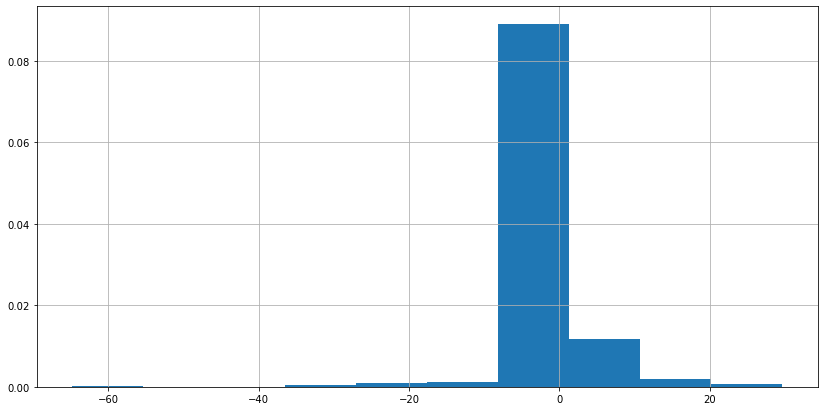

In [3]:
u = Tukey_distribution(0, 1, 20, 0.1, 1000)
plt.figure(figsize=(14,7))
plt.hist(u, density=True)
plt.grid()

## Критерий Стьюдента

In [4]:
from scipy import stats

def Student_test(x, y, alpha):
    # флаг, который указывает, принимаем H0 или отвергаем : 1-отвергаем, 0 - принимаем
    complete = 0
    # вычисляем выборочное среднее
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    # вычисляем выборочную дисперсию
    s_2 = (1 / (len(x) + len(y))) * (np.sum((x - x_mean) ** 2) + np.sum((y - y_mean) ** 2 ))
    # вычисляем статистику критерия, t_value ~ Tukey(m+n-2)
    t_value = (x_mean - y_mean) / ((s_2 * (1 / len(x) + 1 / len(y))) ** 0.5)
    # количество степеней свободы
    df = len(x) + len(y) - 2
    # p-value
    p_value = round((1 - stats.t.cdf(abs(t_value), df)) * 2, 3)
    # принимаем H0 или отвергаем
    if p_value > alpha:
        complete = 0
    else:
        complete = 1
    return t_value, p_value, complete

Протестируем критерий

In [5]:
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)
alpha = 0.1

t_value, p_value, complete = Student_test(x, y, alpha)
t_value, p_value ,complete

(0.2112022575389399, 0.833, 0)

Проверим с результатом из scipy.stats

In [6]:
from scipy import stats
t_value_scipy, p_value_scipy = stats.ttest_ind(x,y)
t_value_scipy, p_value_scipy

(0.21109662999667983, 0.8328333974479989)

In [7]:
if p_value_scipy > alpha:
	print(f'Принимаем гипотезу о равенстве на уровне занчимости {alpha}')
else:
	print(f'Отвергаем гипотезу о равенстве на уровне занчимости {alpha}')

Принимаем гипотезу о равенстве на уровне занчимости 0.1


## Критерий Уилкоксона (Манна-Уитни-Уилкоксона)

In [8]:
def ranging(x, y):
    # объединённая отсортированная выборка
    z = np.sort(np.concatenate((x,y)))
    # массив рангов
    R = np.array([])
    # массив имён 0 - x или 1 - y
    names = np.array([])
    # номер итерации
    i = 1
    # вычисляем ранги и делаем пометку имени x или y
    while i <= len(z):
        # кол-во одинаковых элементов
        xy_count = (z == z[i-1]).sum()
        # если элемент уникален
        if xy_count == 1:
            # добавялем ранг
            R = np.append(R, i)
            if z[i-1] in x:
                # делаем пометку x
                names = np.append(names, 0)
            else:
                # делаем пометку y
                names = np.append(names, 1)
        # если элемент неуникален
        else:
            # кол-во одинаковых x
            x_count = (x == z[i-1]).sum()
            # вычисляем и добавляем ранги
            for j in range(xy_count):
                R = np.append(R, i + (c - 1) / 2)
            # делаем пометку x
            for j in range(x_count):
                names = np.append(names, 0)
            # делаем пометку y
            for j in range(xy_count -x_count):
                names = np.append(names, 1)
        i += xy_count
    return np.append([R], [names], axis = 0)


def Wilcoxon_test(x, y,alpha):
    # флаг, который указывает, принимаем H0 или отвергаем : 1-отвергаем, 0 - принимаем
    complete = 0
    # ранжируем выборку 
    ranged = ranging(x, y)
    w = np.sum(ranged[0], where= ranged[1] == 1)
    # вычисляем мат ожидание
    mw = len(x) / 2 * (len(x) + len(y) + 1)
    # вычисляем дисперсию
    dw = len(x)* len(y) / 12 * (len(x) + len(y) + 1)
    # вычисляем статистику критерия, w_value ~ N(0,1)
    w_value = (w - mw) / (dw ** 0.5)
    # p-value
    p_value = round((1 - stats.norm.cdf((w_value))), 3)
    # принимаем H0 или отвергаем
    if p_value > alpha:
        complete = 0
    else:
        complete = 1
    return w_value, p_value, complete

In [9]:
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)

alpha = 0.1

w_value, p_value, complete = Wilcoxon_test(x, y, alpha)
w_value, p_value ,complete

(-0.021218644738948838, 0.508, 0)

# Тест

## Подсчёт ошибок 2-го рода

In [10]:
def beta_error_frequency(theta, sigma1, sigma2, delta, n, alpha, num_experiments):
    Student_test_result= []
    Wilcoxon_test_result = []
    for i in range(num_experiments):
        x =  Tukey_distribution(0, sigma1, sigma2, delta, n)
        y =  Tukey_distribution(theta, sigma1, sigma2, delta, n)
        Student_test_result.append(Student_test(x, y, alpha)[2])
        Wilcoxon_test_result.append(Wilcoxon_test(x, y, alpha)[2])
    Student_test_frequency = (len(Student_test_result) - sum(Student_test_result)) / len(Student_test_result)
    Wilcoxon_test_frequency = (len(Wilcoxon_test_result) - sum(Wilcoxon_test_result)) / len(Wilcoxon_test_result)
    return Student_test_frequency,  Wilcoxon_test_frequency 

## Функция отрисовки графиков

In [11]:
# график построения частоты ошибок второго рода

def plot_beta_error(a_Student, a_Wilcoxon, param, xlabel):
    fig = plt.figure(figsize=(17, 7))
    plt.grid() 

    plt.title('Beta error frequency')
    plt.plot(param, a_Student, color='green',label='Критерий Стьюдена')
    plt.plot(param, a_Wilcoxon, color='red',label='Критерий Вилкоксона')
    plt.xlabel(xlabel)
    plt.ylabel('freq')
    plt.legend()
    plt.grid(True) 
    plt.show()

## sigma2 меняется, все остальные параметры const

In [18]:
num_experiments = 500
n = 200
alpha = 0.05
theta = 3
delta = 0.1
sigma1 = 1
sigma2 = [i for i in range(10, 30)]

Student_test_frequency_res = []
Wilcoxon_test_frequency_res  = []

In [19]:
for sig2 in sigma2:
    s, w = beta_error_frequency(theta, sigma1, sig2, delta, n, alpha, num_experiments)
    Student_test_frequency_res.append(s)
    Wilcoxon_test_frequency_res.append(w)

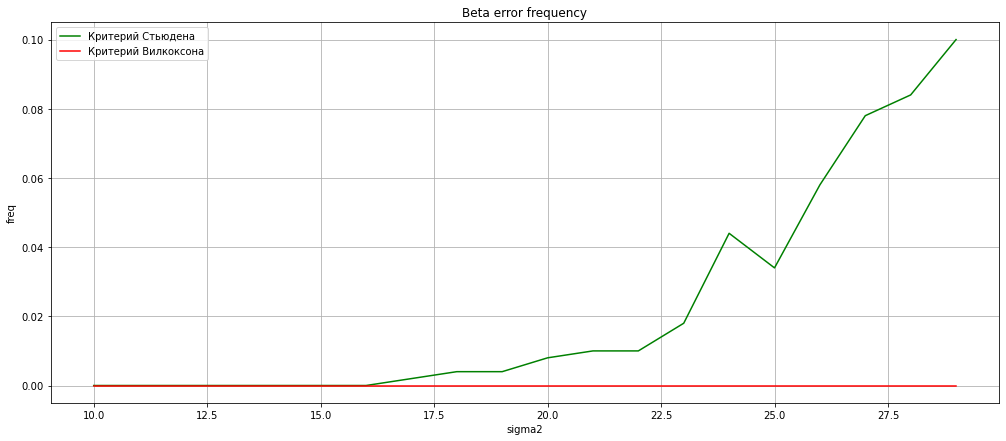

In [20]:
plot_beta_error(Student_test_frequency_res, Wilcoxon_test_frequency_res, sigma2,'sigma2')

## delta меняется, все остальные параметры const

In [15]:
num_experiments = 500
n = 200
alpha = 0.05
theta = 3
delta = np.arange(0, 1, 0.025)
sigma1 = 1
sigma2 = 10

Student_test_frequency_res = []
Wilcoxon_test_frequency_res  = []

In [16]:
for delt in delta:
    s, w = beta_error_frequency(theta, sigma1, sigma2, delt, n, alpha, num_experiments)
    Student_test_frequency_res.append(s)
    Wilcoxon_test_frequency_res.append(w)

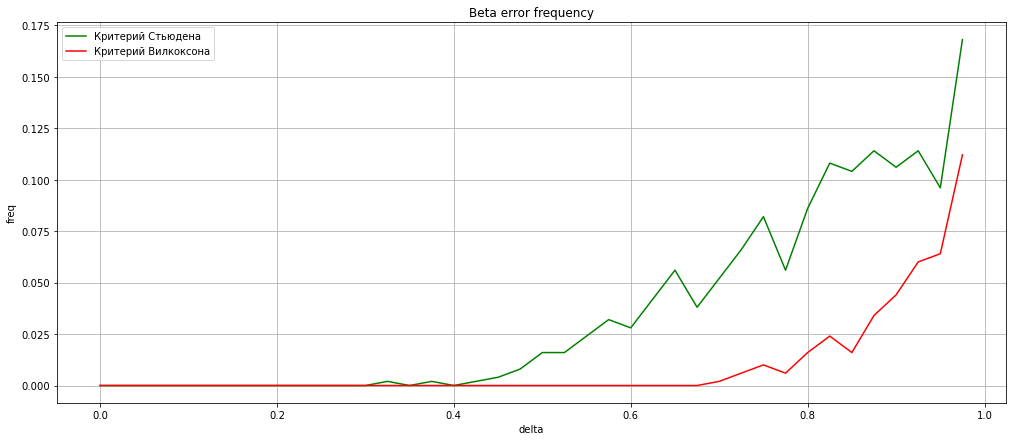

In [17]:
plot_beta_error(Student_test_frequency_res, Wilcoxon_test_frequency_res, delta, 'delta')

## theta меняется, все остальные параметры const

In [18]:
num_experiments = 500
n = 200
alpha = 0.05
theta = np.arange(0, 3.1, 0.1)
delta = 0.1
sigma1 = 1
sigma2 = 10

Student_test_frequency_res = []
Wilcoxon_test_frequency_res  = []

In [19]:
for theta_ in theta:
    s, w = beta_error_frequency(theta_, sigma1, sigma2, delta, n, alpha, num_experiments)
    Student_test_frequency_res.append(s)
    Wilcoxon_test_frequency_res.append(w)

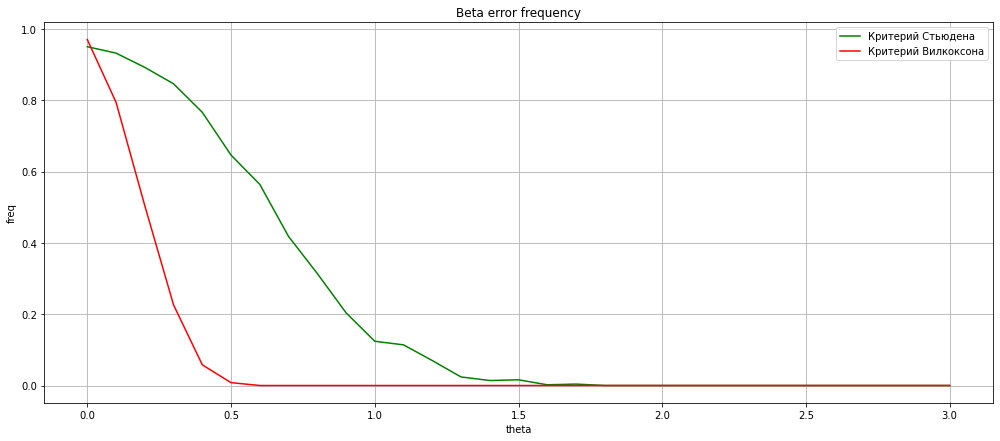

In [20]:
plot_beta_error(Student_test_frequency_res, Wilcoxon_test_frequency_res, theta, 'theta')